In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from datetime import timedelta
from sklearn import preprocessing
from IPython.display import display
import operator

In [2]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

# Classes and Functions

In [3]:
def BarsAndPies (col,df_focus,noPie=False,titleVal=None):
    valCount = len(df_focus[col].unique())
    ax=x=y=None
    orient='h'
    height = 4
    width = 8
    
    if not titleVal:
        titleVal = '\"{}\"'.format(col)
    barPlotTitle = 'Counts for Values of {}'.format(titleVal)
  
    # very big, go vetical
    if valCount > 30:
        y=df_focus[col]
        height = valCount/6
        orient='v'
        plt.figure(figsize=(width,height))
        plt.title(barPlotTitle)

    # for small number of values add a pie chart
    elif ((valCount < 4) & (not noPie)):  
        x=df_focus[col]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width,height))
        ax=ax1
        ax1.set_title(barPlotTitle)
        ax2.set_title('Percentages for Values of ' + titleVal)
        
        labels = df_focus[col].astype('category').cat.categories.tolist()
        counts = df_focus[col].value_counts()
        sizes = [counts[var_cat] for var_cat in labels]

        ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
        ax2.axis('equal')
    
    else:             
        x=df_focus[col]
        newWidth = valCount/2
        if newWidth > width:
                width = newWidth
        plt.figure(figsize=(width,height))
        plt.title(barPlotTitle)

    b = sns.countplot(x=x,
                      y=y,
                      data=df_focus, 
                      orient=orient, 
                      order = df_focus[col].value_counts().index,
                      ax=ax)
    maxValLen = max([len(str(i)) for i in df_focus[col].unique()])
    if ((valCount > 4) & (maxValLen > 4) & (orient is not 'v')):
        plt.setp(b.get_xticklabels(), rotation=90)
    plt.show()

In [4]:
def BoxHist(column, df_focus, bins=10, titleVal=False):
    
    sns.set()
    colList = df_focus[column]
    
    if not titleVal:
        titleVal = '\"{}\"'.format(column)
    plotTitle = 'Values for {}'.format(titleVal)
    
    # plots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=column, data=df_focus)
    
    plt.subplot(1, 2, 2)
    g=sns.distplot(colList, kde=False, bins=bins)
    
    # rotate label for large tick values on histagram x axis
    if (colList.max() > 9999):
        plt.setp(g.get_xticklabels(), rotation=45)

    plt.suptitle(plotTitle)
    plt.show()

In [5]:
def GridSearchTablePlot(gridClf, paramName,
                          num_results=15,
                          negative=False,
                          graph=True,
                          displayAllParams=False,
                          largeTable=False):

    clf = gridClf.best_estimator_
    clf_params = gridClf.best_params_
    if negative:
        clf_score = -gridClf.best_score_
    else:
        clf_score = gridClf.best_score_
    clf_stdev = gridClf.cv_results_['std_test_score'][gridClf.best_index_]
    cv_results = gridClf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if displayAllParams:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + paramName]

 
    # display abreviated top 'num_results' results
    if largeTable:
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    else:
        abrevCols = ['mean_test_score','std_test_score']
        abrevCols += [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results)[abrevCols])
        

    # plot the results
    [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
    scores_df = scores_df.sort_values(by='param_' + paramName)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + paramName]

    # plot
    if graph:
        plt.figure(figsize=(8, 4))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(paramName + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(paramName)
        plt.ylabel('Score')
        plt.show()

In [6]:
import time
from sklearn.model_selection import cross_val_score

class Model(object):
    
    def __init__(self,name,X,Y,modelObj,**modelParams):
        self.params = modelParams
        self.modelObj = modelObj.set_params(**self.params)  
        self.name = name
        self.X = X
        self.Y = Y
        self.initValues()   
    
    def initValues(self):
        start = time.time()
        self.modObjFit = self.modelObj.fit(self.X, self.Y)
        end = time.time()
        self.timeToFit = end - start
        self.crossVal = cross_val_score(self.modelObj, self.X, self.Y, cv=5)
        self.crossValMean = np.mean(self.crossVal)
        self.crossValRange = max(self.crossVal) - min(self.crossVal)
         
    def performance(self, boxPlot=True):
        print ("Model:\t\t" + str(self.name))
        print ("CV Mean:\t" + str(self.crossValMean))
        print ("CV Range:\t" + str(self.crossValRange))
        print ("Train Time:\t" + str(self.timeToFit))
        print ("CV Scores: ")
        print (self.crossVal)
        if boxPlot:
            fig = plt.figure()
            title = "Performance: %s" % (self.name)
            fig.suptitle(title)
            ax = fig.add_subplot(111)
            plt.boxplot(self.crossVal, showmeans=True)
            ax.set_xticklabels(self.name)
            plt.show()
    
    def compareBox(self,modelList,filterResult=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.crossVal)
        names.append(self.name)
        
        for rightModel in modelList:
            if filterResult > 0:
                if rightModel.crossVal.mean() > filterResult:
                    results.append(rightModel.crossVal)
                    names.append(rightModel.name)
            else:
                results.append(rightModel.crossVal)
                names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results, showmeans=True)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels,folds=False):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        cvNameList= []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToFit,
                                'CV Mean':model.crossValMean,
                                'CV Range': model.crossValRange}
            if folds:  
                buildCvNameList = False
                if not cvNameList:
                    buildCvNameList=True
                for idx,cv in enumerate(model.crossVal):
                    cvName = 'CV Fold ' + str(idx+1)
                    if buildCvNameList:
                        cvNameList.append(cvName)
                    dataRowForFrame[cvName] = cv
            dataForFrame.append(dataRowForFrame)
        colOrder = ['Name', 'CV Mean', 'CV Range', 'Time']
        colOrder += cvNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels)    

# Data Set Information


https://www.kaggle.com/kemical/kickstarter-projects

In [7]:
df=df.sample(10000, random_state=32)

In [8]:
df.shape

(10000, 15)

In [9]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
711859,292924641,"NextGen, Use any platform on any devive, rules...",Software,Technology,SEK,2014-11-04,50000,2014-10-21 15:14:46,0,failed,0,SE,0,0.00,6726.22
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,Fiction,Publishing,USD,2012-07-12,1000,2012-06-28 01:35:01,1505,successful,43,US,1505,1505.00,1000.00
305960,1549399998,· Guenda · products for connecting with nature...,Embroidery,Crafts,MXN,2017-12-25,60000.00,2017-11-25 15:56:14,60520.00,successful,84,MX,112.64,3067.57,3041.21
56190,1111918633,The ABCs of Nightmares,Children's Books,Publishing,CAD,2016-11-24,8500.00,2016-10-24 01:05:08,2764.00,failed,49,CA,0,2048.77,6300.50
867977,7.40164e+08,The Toughest,Documentary,Film & Video,USD,2016-04-02,2295.00,2016-03-03 15:46:40,0.00,failed,0,US,0,0.00,2295.00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 711859 to 1038110
Data columns (total 15 columns):
ID                  10000 non-null object
name                10000 non-null object
category            10000 non-null object
main_category       10000 non-null object
currency            10000 non-null object
deadline            10000 non-null object
goal                10000 non-null object
launched            10000 non-null object
pledged             9999 non-null object
state               9999 non-null object
backers             9999 non-null object
country             9999 non-null object
usd pledged         9897 non-null object
usd_pledged_real    9999 non-null float64
usd_goal_real       9999 non-null float64
dtypes: float64(2), object(13)
memory usage: 1.2+ MB


# Data Cleaning

Since we have such a large data set most of the cleaning will be handled by dropping the data rather than imputing.

## Drop Columns

### Outcome Related, Duplicate and Identifiers

"pledged" and "backers" are outcome variables (i.e. they are not known until the end of the campaign). These may be used to determine the popularity of a campaign or the magnitude of success. For this effort, though, we are trying to predict the outcome.  These variables would not be available until the outcome has occurred. 

Other columns contain money amounts related to the campaign.  We will just be using the US Dollar as the standard for the goal money amounts.  This is contained in the "usd_goal_real" variable. The other money columns can be dropped.  Adios pesos. 

Identifiers columns such as "ID" and "name" are not needed either so this will be dropped as well.


In [11]:
dfDropCols = df.copy()
dfDropCols = dfDropCols.drop(['usd pledged',
                              'usd_pledged_real',
                              'pledged',
                              'backers',
                              'goal',
                              'currency',
                              'name',
                              'ID'], axis=1)

## Drop Rows

### Null Values

There are very few nulls. 

In [12]:
total = dfDropCols.isnull().sum().sort_values(ascending=False)
percent = (dfDropCols.isnull().sum()/dfDropCols.isnull().count()).sort_values(ascending=False)
dfDropCols_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(dfDropCols_missingData.head(20))
dfDropCols.isnull().sum().max()

,Total,Percent
usd_goal_real,1,0.0001
country,1,0.0001
state,1,0.0001
launched,0,0.0000
deadline,0,0.0000
main_category,0,0.0000
category,0,0.0000


1

In [13]:
dfNoNulls = dfDropCols.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", dfDropCols.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", dfDropCols.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/dfDropCols.shape[0]))   

Before Dropping Nulls:  10000
After Dropping Nulls:  9999
Rows Removed:  1
Percent Removed: 0%


### Campaigns Not Success or Failure

We are only interested in the campaigns that succeeded or failed so dropping campaign in any other state.

In [14]:
dfDropState = dfNoNulls.copy()
dropVals = ['live',
            'suspended',
            'canceled',
            'fnceled',
            'undefined']
for dv in dropVals:
    dfDropState = dfDropState.drop(dfDropState[(dfDropState['state'] == dv)].index)

print ("Before Dropping: ", dfNoNulls.shape[0])
print ("After Dropping: ", dfDropState.shape[0])
print ("Rows Removed: ", dfNoNulls.shape[0] - dfDropState.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfDropState.shape[0])/dfNoNulls.shape[0]))       

Before Dropping:  9999
After Dropping:  8794
Rows Removed:  1205
Percent Removed: 12%


In [15]:
# fix index
dfDropState.reset_index(inplace=True, drop=True)

### Convert Date Data

The "launched" and "deadline" variables will need to be "datetime" type.

In [16]:
dfDates = dfDropState.copy()
dfDates[['launched','deadline']] = dfDates[['launched','deadline']].apply(pd.to_datetime)

# Univariate Exploration

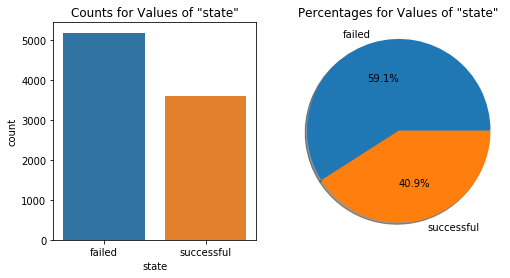

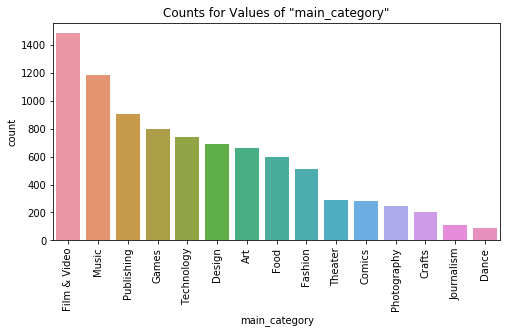

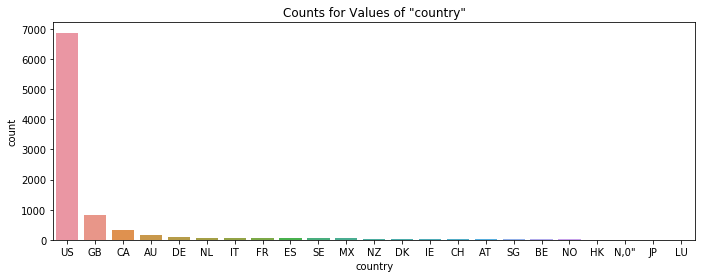

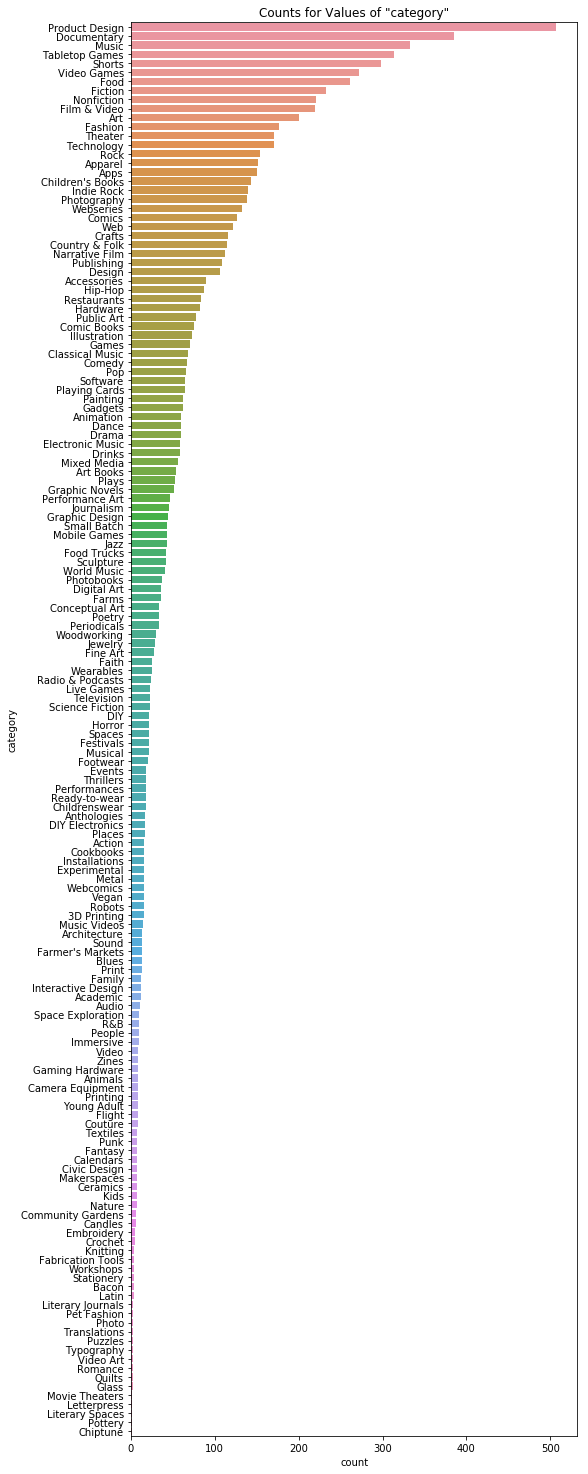

In [17]:
catCols = ['state','main_category','country','category']
for col in catCols:
    BarsAndPies(col,dfDates)

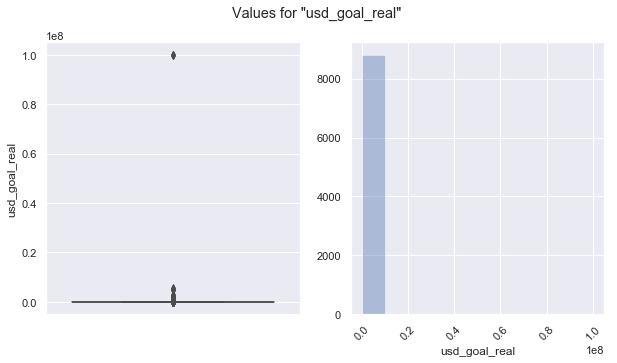

In [18]:
BoxHist('usd_goal_real',dfDropState)

# Feature Creation

In [19]:
dfBuildFeats = dfDropState.copy()

## State Encoding
Success of failure will be encoded as "1" and "0" for modeling.

In [20]:
dfBuildFeats['state'] = dfBuildFeats.state.astype('category')
dfBuildFeats['state_code'] = np.where(dfBuildFeats['state'].str.contains('successful'),1,0)

## Length of Campaign Calculation

The "launched" and "deadline" variables will be utilezed to determine the length of a Kickstarter campaign

In [21]:
dfBuildFeats['CampaignLength'] = (pd.to_datetime(dfBuildFeats['deadline']) 
                           - pd.to_datetime(dfBuildFeats['launched'])).dt.days + 1

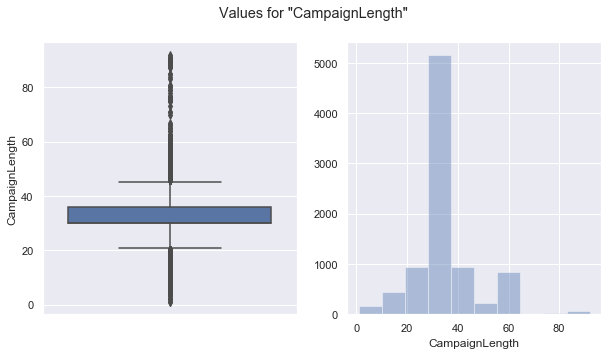

In [22]:
BoxHist('CampaignLength', dfBuildFeats)

## Subcategory Convert to Numerical

There are too many subcategories to do one hot encoding for.  This would result in too many features.  Instead the values will be converted to numerical values.

In [23]:
le = preprocessing.LabelEncoder()
le.fit(dfBuildFeats['category'])
ar = le.transform(dfBuildFeats['category'])
dfBuildFeats['num_category'] = ar

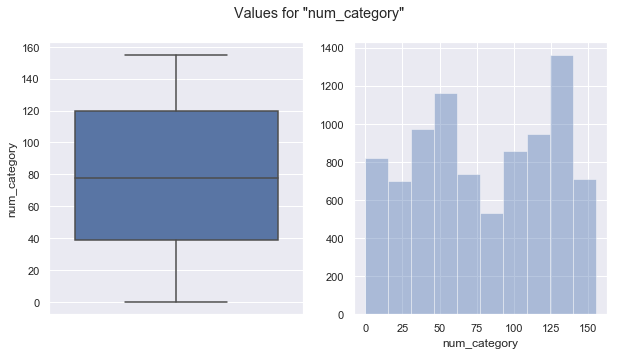

In [24]:
BoxHist('num_category',dfBuildFeats)

## Country US or Not

The US has the most campaigns by far.  This feature will combine all other countries into a single value.  The feature will indicate whether the campaign took place in the US or not.

In [25]:
dfBuildFeats['US'] = np.where(dfBuildFeats['country'].str.contains('US'),1,0)

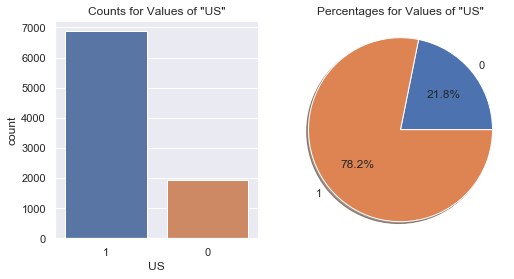

In [26]:
BarsAndPies('US',dfBuildFeats)

## Category One Hot Encoding
Categories values will converted to columns and assigned a True/False based on whether the row belongs to that category or not.

In [27]:
dfEnc = dfBuildFeats.copy()
dfEnc = pd.get_dummies(dfEnc, columns=['main_category'], prefix = ['cat'])

# Create Final Feature Set
Drop all variables that will not be used in the models.

In [28]:
dfFeats = dfEnc.copy()
dfFeats = dfFeats.drop(['category',
                        'deadline',
                        'launched',
                        'state',
                        'country'],axis=1)

# Set Data and Target

In [29]:
y=dfFeats['state_code']
X=dfFeats.drop('state_code', axis=1)

In [30]:
y.unique()

array([0, 1])

In [31]:
X.shape

(8794, 19)

In [32]:
X.head()

,usd_goal_real,CampaignLength,num_category,US,cat_Art,cat_Comics,cat_Crafts,cat_Dance,cat_Design,cat_Fashion,cat_Film & Video,cat_Food,cat_Games,cat_Journalism,cat_Music,cat_Photography,cat_Publishing,cat_Technology,cat_Theater
0,6726.22,14,130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1000.00,14,54,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3041.21,30,43,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,6300.50,31,19,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2295.00,30,39,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Baseline

In [33]:
from collections import Counter
counts = Counter(y)
baseline = counts[1]/len(y)
print ("BASELINE: {}".format(baseline))

BASELINE: 0.40948373891289513


# Models 

### Random Forest

Model:		Random Forest
CV Mean:	0.648510750248
CV Range:	0.0134474999693
Train Time:	0.3440427780151367
CV Scores: 
[ 0.65056818  0.64070495  0.64866401  0.65415245  0.64846416]


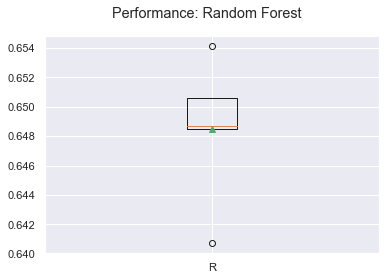

In [34]:
rfModelParams = {'n_estimators':22,
                 'max_depth':19,
                 'max_features':9,
                 'criterion':'entropy'}
rfModel = Model('Random Forest',X,y,ensemble.RandomForestClassifier(),**rfModelParams)
rfModel.performance()

### Gradient Boost

Model:		Gradient Boost
CV Mean:	0.678530266473
CV Range:	0.0178128280302
Train Time:	0.9562010765075684
CV Scores: 
[ 0.67670455  0.68050028  0.68504832  0.68316268  0.66723549]


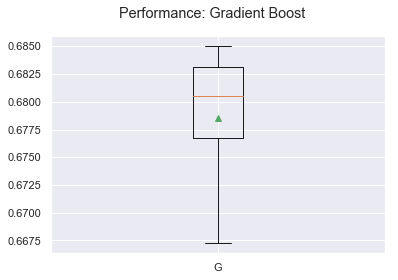

In [35]:
gbModelParams = {'n_estimators':128,
                 'max_depth':4,
                 'loss':'exponential'}
gbModel = Model('Gradient Boost',X,y,ensemble.GradientBoostingClassifier(),**gbModelParams)
gbModel.performance()

# Neural Networks

In [42]:
# Import the model.
from sklearn.neural_network import MLPClassifier


Model:		MLP
CV Mean:	0.598588839625
CV Range:	0.0224048465845
Train Time:	0.9369511604309082
CV Scores: 
[ 0.59431818  0.6122797   0.60318363  0.58987486  0.59328783]


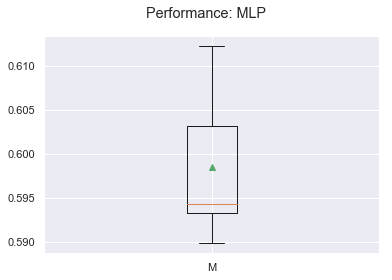

In [43]:
mlpModelParamsP = {'hidden_layer_sizes':(100,20,20,20,20)}
mlpModelP20by4 = Model('MLP',X,y,MLPClassifier(),**mlpModelParamsP)
mlpModelP20by4.performance()

Model:		MLP 1000,1000,1000,1000
CV Mean:	0.613257496235
CV Range:	0.0169303961113
Train Time:	100.72129893302917
CV Scores: 
[ 0.61818182  0.61512223  0.61512223  0.60125142  0.61660978]


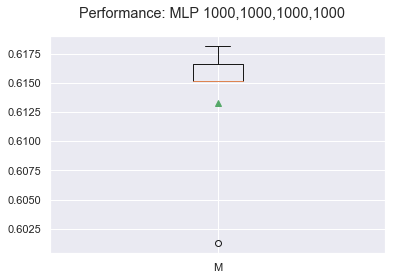

In [45]:
mlpModelParamsP = {'hidden_layer_sizes':(1000,1000,1000,1000)}
svmModelP1000by4 = Model('MLP 1000,1000,1000,1000',X,y,MLPClassifier(),**mlpModelParamsP)
svmModelP1000by4.performance()

Model:		MLP 1000,1000,1000
CV Mean:	0.595065596559
CV Range:	0.0489192263936
Train Time:	34.727599143981934
CV Scores: 
[ 0.58920455  0.59806708  0.59693007  0.57110353  0.62002275]


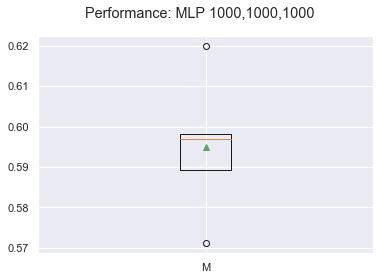

In [46]:
mlpModelParamsP = {'hidden_layer_sizes':(1000,1000,1000)}
mlpModel1000by3 = Model('MLP 1000,1000,1000',X,y,MLPClassifier(),**mlpModelParamsP)
mlpModel.performance()

,Name,CV Mean,CV Range,Time
0,"MLP 1000,1000,1000",0.595066,0.048919,34.727599
1,Gradient Boost,0.678530,0.017813,0.956201
2,Random Forest,0.648511,0.013447,0.344043


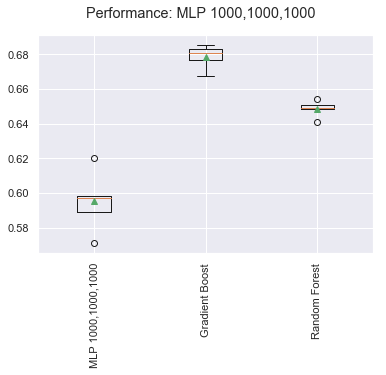

In [49]:
mlpModel.fullCompareList([gbModel,rfModel])